## CP7: Systematic Errors

In [78]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy.integrate import quad
import math

In [79]:
# load in data from first file
m = np.loadtxt('datafile-expresonance.txt')
# set min and max range of mass samples taken given in notes
mmin = 0.
mmax = 10.

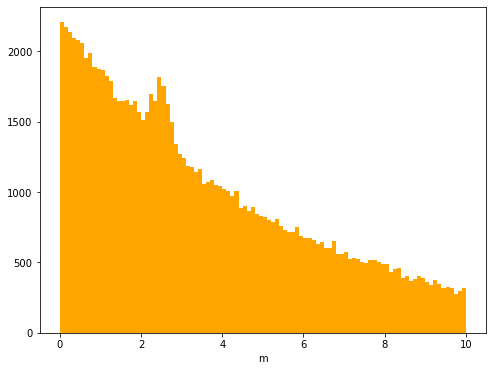

In [80]:
# plot histogram of data
plt.figure(figsize=(8,6))
plt.hist(m , bins=100, color='orange')
plt.xlabel('m')
plt.show()

Histogram looks as expected, an exponential background with a small peak centred on a mass of ~2.5 and masses are indeed in range 0 to 10

# Part 1

In [81]:
def func_full(m, lifetime, mean, F):
    # evaluates sum of normalsied exponential background and Gaussian signal for a given background 'lifetime',
    # signal mean and background fraction F
    
    gaussian = np.exp(-0.5 * ((m - mean)/sigma)**2)
    # fixing sigma to a small enough value such as 0.2 means it tails off to zero well within the range of interest
    # so we can safely approximate our normalisation to the normalisation between +/- infinity
    gaussian_norm = sigma*np.sqrt(2*np.pi)
    gaussian = gaussian / gaussian_norm
    
    # exponential normalised analytically given mass range defined earlier, equally could do numerical integration with quad
    expon = np.exp(-m/lifetime)
    expon_norm = lifetime * (np.exp(-mmin/lifetime) - np.exp(-mmax/lifetime))
    expon = expon / expon_norm
    
    # expecting F between 0 and 1 means summing like this preserves normalisation after summing
    return (1-F)*gaussian + F*expon 

In [82]:
def nll_full(lifetime, mean, F):
    # nll (negative log likelihood) for exponential background and Gaussian signal model for fit parameters
    # background 'lifetime', gaussian mean and background fraction F
    pdf = func_full(m, lifetime, mean, F)
    nll = -1 * np.sum(np.log(pdf))
    return nll

In [83]:
# fix sigma to 0.2 as recommended in notes
sigma = 0.2
# fit Minuit, with initial guesses for background lifetime, signal mean and background fraction F
fit1 = Minuit(nll_full, lifetime=4., mean=3., F=0.9)
# definition of error for nll given in notes
fit1.errordef = 0.5
fit1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.146e+05                  │              Nfcn = 103              │
│ EDM = 1.31e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ lifetime │   5.008   │   0.031   │            │            │         │         │       │
│ 1 │ mean     │   2.499   │   0.015   │            │            │         │         │       │
│ 2 │ F        │  0.9796   │  0.0012   │            │            │         │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────────────┐
│          │  lifetime      mean         F │
├──────────┼───────────────────────────────┤
│ lifetime │  0.000945  -1.7e-05 -4.01e-06 │
│     mean │  -1.7e-05  0.000212  6.99e-07 │
│        F │ -4.01e-06  6.99e-07  1.33e-06 │
└──────────┴───────────────────────────────┘

All green so fit was successful. For one particular fit, parameter best estimates were:

- lifetime (called 'A' in notes) $= 5.008\pm0.031$
- mean (called 'M' in notes) $= 2.499\pm0.015$
- signal fraction F $= 0.09796\pm0.0012$

Errors are quoted to maximum two significant figures and best estimage is quoted to same number of decimal places. 

In [84]:
# get parameter best estimates
lifetime_fit1 = fit1.values["lifetime"]
mean_fit1 = fit1.values["mean"]
F_fit1 = fit1.values["F"]

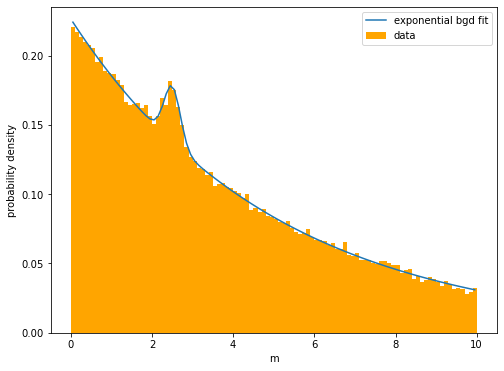

In [85]:
# plot histogram to inspect fit
plt.figure(figsize=(8,6))
# get xs which are the values of the bin centres
counts, bin_edges, _ = plt.hist(m, bins=100, color='orange', density=True, label='data')
tot_bin_edges = np.array(bin_edges)
half_bin_width = (tot_bin_edges[1] - tot_bin_edges[0]) / 2.
xs = (tot_bin_edges + half_bin_width)[:-1]
# plot the pdf given parameter best estimates on top of histogram
plt.plot(xs, func_full(xs, lifetime_fit1, mean_fit1, F_fit1), label='exponential bgd fit')
plt.ylabel('probability density')
plt.xlabel('m')
plt.legend(loc='best')
plt.show()

Fit looks good as expected for assumed best model

# Part 2

In [86]:
def poly_bgd_func(m, b, c, mean, F):
    # evaluates sum of normalsied 2nd degree polynomial background and Gaussian signal given b and c polynomial coefficients

    gaussian = np.exp(-0.5 * ((m - mean)/sigma)**2)
    # fixing sigma to a small enough value such as 0.2 means it tails off to zero well within the range of interest
    # so we can safely approximate our normalisation to the normalisation between +/- infinity
    gaussian_norm = sigma*np.sqrt(2*np.pi)
    gaussian = gaussian / gaussian_norm
    
    # polynomial background normalised analytically
    # 'a' is set to one later as recommended in notes
    poly = a + b*m + c*m**2
    poly_norm = a*mmax + (b/2)*mmax**2 + (c/3)*mmax**3 - (a*mmin + (b/2)*mmin**2 + (c/3)*mmin**3)
    poly = poly / poly_norm
    # at high mass end, correct any negative predictions to a small positive value to prevent negative encountered in nll
    for i in range(len(poly)):
        if poly[i] < 0:
            poly[i] = 1e-9
    # expecting F between 0 and 1 means summing like this preserves normalisation after summing
    return (1-F)*gaussian + F*poly

In [87]:
def nll_poly(b, c, mean, F):
    # nll for polynomial background and Gaussian signal model for fit parameters background b & c, gaussian mean and background fraction F
    pdf = poly_bgd_func(m, b, c, mean, F)
    nll = -1 * np.sum(np.log(pdf))
    return nll

In [88]:
# set polynomial 'a' to one as recommended in notes
a = 1.
fit2 = Minuit(nll_poly, b=-0.016, c=0.007, mean=3., F=0.9)
fit2.errordef = 0.5
fit2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.146e+05                  │              Nfcn = 184              │
│ EDM = 7.83e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b    │  -0.1578  │  0.0011   │            │            │         │         │       │
│ 1 │ c    │  7.30e-3  │  0.12e-3  │            │            │         │         │       │
│ 2 │ mean │   2.494   │   0.016   │            │            │         │         │       │
│ 3 │ F    │  0.9820   │  0.0012   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬─────────────────────────────────────────┐
│      │         b         c      mean         F │
├──────┼─────────────────────────────────────────┤
│    b │  1.14e-06 -1.23e-07 -5.72e-07 -3.44e-08 │
│    c │ -1.23e-07   1.4e-08  5.73e-08 -6.65e-10 │
│ mean │ -5.72e-07  5.73e-08  0.000244  7.02e-07 │
│    F │ -3.44e-08 -6.65e-10  7.02e-07  1.35e-06 │
└──────┴─────────────────────────────────────────┘

All green so fit was successful.

In [89]:
# best estimates
b_fit2 = fit2.values["b"]
c_fit2 = fit2.values["c"]
mean_fit2 = fit2.values["mean"]
F_fit2 = fit2.values["F"]

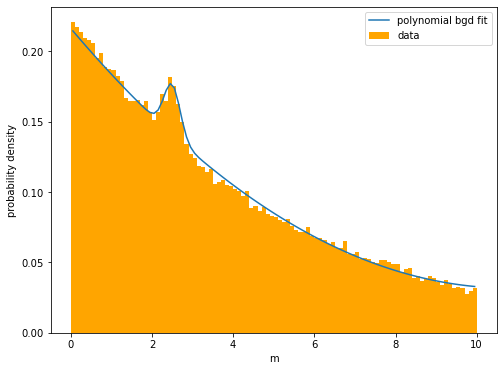

In [90]:
# plot histogram to inspect fit
plt.figure(figsize=(8,6))
counts, bin_edges, _ = plt.hist(m, bins=100, color='orange', density=True, label='data')
tot_bin_edges = np.array(bin_edges)
half_bin_width = (tot_bin_edges[1] - tot_bin_edges[0]) / 2.
xs = (tot_bin_edges + half_bin_width)[:-1]
plt.plot(xs, poly_bgd_func(xs, b_fit2, c_fit2, mean_fit2, F_fit2), label='polynomial bgd fit')
plt.ylabel('probability density')
plt.xlabel('m')
plt.legend(loc='best')
plt.show()

Fit looks good

In [91]:
# systematic error in Gaussian mean given by difference in estimate of both part 1 and part 2 fits called 'shift' method
sys_error = abs(mean_fit2 - mean_fit1)
# round value to 2 significant figures
sys_error = round(sys_error, 2 - int(math.floor(math.log10(abs(sys_error)))) - 1)
sys_error

0.0042

For primary best estimate for Gaussian mean found in part 1:

$Value\pm E_{stat}\pm E_{syst}$
- M $= 5.008\pm 0.031\pm 0.004$

$Value\pm E_{tot}$ given by adding statistical and sytematic errors in quadrature.
- M $= 5.008\pm 0.031$

Polynomial background fit is a close enough model to the original that the systematic error in the Gaussian mean is insignificant in comparison to the statisitcal error. If we assume these two are the only possibilities for modeling the background, we claim the systematic error in the signal mean is unimportant and could be discarded.

# Part 3

In [92]:
def lin_bgd_func(m, b, mean, F):
    # evaluates sum of normalsied linear background and Gaussian signal
    
    gaussian = np.exp(-0.5 * ((m - mean)/sigma)**2)
    gaussian_norm = sigma*np.sqrt(2*np.pi)
    gaussian = gaussian / gaussian_norm
    
    # linear background normalised analytically
    linear = a + b*m
    linear_norm = a*mmax + (b/2)*mmax**2 - (a*mmin + (b/2)*mmin**2)
    linear = linear / linear_norm
    # at high mass end, correct any negative predictions to a small positive value to prevent negative encountered in nll
    for i in range(len(linear)):
        if linear[i] < 0:
            linear[i] = 1e-9
    # expecting F between 0 and 1 means summing like this preserves normalisation after summing
    return (1-F)*gaussian + F*linear

In [93]:
def nll_lin(b, mean, F):
    # nll for linear background and Gaussian signal model for fit parameters linear gradient b, gaussian mean and background fraction F
    pdf = lin_bgd_func(m, b, mean, F)
    nll = -1 * np.sum(np.log(pdf))
    return nll

In [94]:
fit3 = Minuit(nll_lin, b=-0.09, mean=3., F=0.9)
fit3.errordef = 0.5
fit3.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.155e+05                  │              Nfcn = 93               │
│ EDM = 1.21e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b    │ -90.40e-3 │  0.22e-3  │            │            │         │         │       │
│ 1 │ mean │   2.465   │   0.015   │            │            │         │         │       │
│ 2 │ F    │  0.9801   │  0.0012   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬───────────────────────────────┐
│      │         b      mean         F │
├──────┼───────────────────────────────┤
│    b │  4.97e-08  -5.1e-08 -3.36e-08 │
│ mean │  -5.1e-08  0.000229  6.02e-07 │
│    F │ -3.36e-08  6.02e-07  1.35e-06 │
└──────┴───────────────────────────────┘

All green so fit was successful.

In [95]:
# best estimates
b_fit3 = fit3.values["b"]
mean_fit3 = fit3.values["mean"]
F_fit3 = fit3.values["F"]

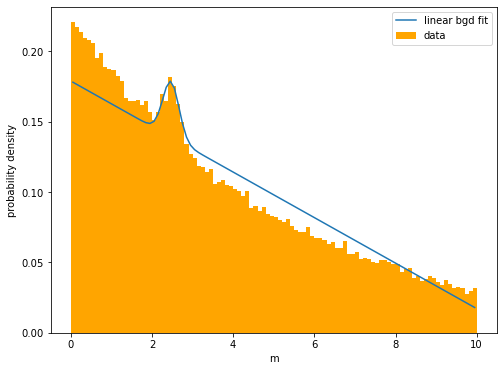

In [96]:
# plot histogram of second dataset
plt.figure(figsize=(8,6))
counts, bin_edges, _ = plt.hist(m, bins=100, color='orange', density=True, label='data')
tot_bin_edges = np.array(bin_edges)
half_bin_width = (tot_bin_edges[1] - tot_bin_edges[0]) / 2.
xs = (tot_bin_edges + half_bin_width)[:-1]
plt.plot(xs, lin_bgd_func(xs, b_fit3, mean_fit3, F_fit3), label='linear bgd fit')
plt.ylabel('probability density')
plt.xlabel('m')
plt.legend(loc='best')
plt.show()

Fit doesn't look great but this is expected for a linear background model so is acceptable.

In [97]:
# array of all three best estimates for M
mean_fits = np.array([mean_fit1, mean_fit2, mean_fit3])
mean_fits

array([2.49853324, 2.49429419, 2.46537811])

In [98]:
# now considering all three background models, systematic error in M is greatest difference between pairs of best estimates
sys_error = abs(np.max(mean_fits) - np.min(mean_fits))
sys_error = round(sys_error, 2 - int(math.floor(math.log10(abs(sys_error)))) - 1)
sys_error

0.033

For primary best estimate for Gaussian mean found in part 1:

$Value\pm E_{stat}\pm E_{syst}$
- M $= 5.008\pm 0.031\pm 0.033$

$Value\pm E_{tot}$ given by adding statistical and systematic errors in quadrature
- M $= 5.008\pm 0.045$

Linear background fit is a different enough model to the others that the systematic error in the Gaussian mean is comparable to the statistical error. If we believe that the linear background model is a real possibility as well as the other two models, the systematic error in the signal mean becomes important and cannot be discarded.